In [1]:
### setting for remote python debug, such as jupyter or pycharm, to avoid bedtools calling error
### run before "import scglue"
import os
from os import path
import sys
import shutil
import subprocess
bin_dir = path.dirname(sys.executable)
os.environ['PATH'] += os.pathsep + bin_dir #
## shutil.which('bedtools')
## subprocess.run(['bedtools', '--help'])

# import pybedtools
# pybedtools.set_bedtools_path('/mnt/disk1/xzhou/anaconda3/envs/PyG/bin/') ## 这里提前设置否则"sortBed"找不到
# # pybedtools.set_bedtools_path('/mnt/disk1/xzhou/code/')
# import importlib
# pybedtools = importlib.reload(pybedtools)
# print(pybedtools.settings.bedtools_version)
# print(pybedtools.helpers._version_2_15_plus_names("sortBed"))
# print(pybedtools.settings._bedtools_installed)

import pandas as pd
import anndata as ad
import networkx as nx
import scanpy as sc
import scglue
from matplotlib import rcParams

/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
atac=ad.read_h5ad("/mnt/disk1/xiaojk/data/mouse/peakmatrix_seurat_data_e13.h5ad")

In [3]:
attributes_to_remove = ['nCount_RNA', 'nFeature_RNA']

# 删除属性
atac.obs.drop(attributes_to_remove, axis=1, inplace=True)

In [4]:
atac.var.head(10)

,features
chr1-3120258-3120758,chr1-3120258-3120758
chr1-3212732-3213232,chr1-3212732-3213232
chr1-3292521-3293021,chr1-3292521-3293021
chr1-3293438-3293938,chr1-3293438-3293938
chr1-3333589-3334089,chr1-3333589-3334089
chr1-3360810-3361310,chr1-3360810-3361310
chr1-3368156-3368656,chr1-3368156-3368656
chr1-3369553-3370053,chr1-3369553-3370053
chr1-3395183-3395683,chr1-3395183-3395683
chr1-3395737-3396237,chr1-3395737-3396237


In [5]:
#稀疏矩阵转化为索引
atac.X.tocoo()
atac.obs.insert(0, 'domain', 'scATAC-seq')

In [6]:
#使用函数 scglue.data.lsi 进行潜在语义索引(LSI)降维
scglue.data.lsi(atac, n_components=100, n_iter=15)

/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/scglue/num.py:289: RuntimeWarning: divide by zero encountered in true_divide
  idf = X.shape[0] / X.sum(axis=0)


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-

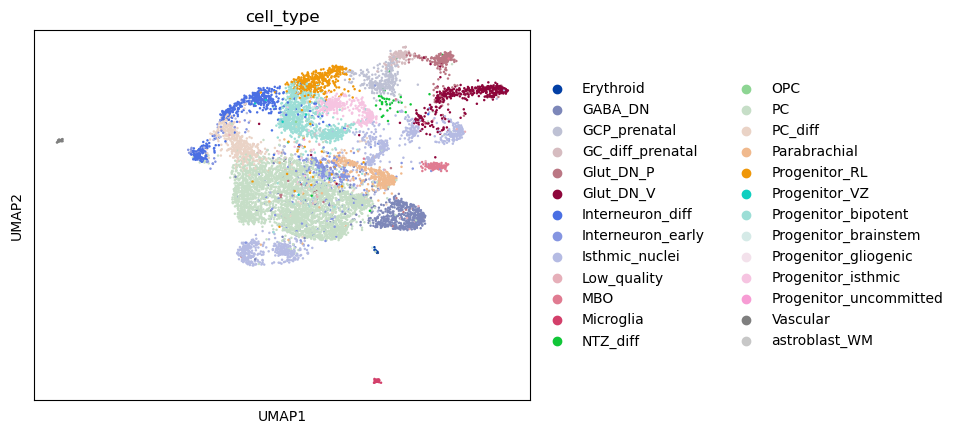

In [7]:
#UMAP将ATAC模态可视化
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)
sc.pl.umap(atac, color="cell_type")

In [8]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac.var.head()

,features,chrom,chromStart,chromEnd
chr1-3120258-3120758,chr1-3120258-3120758,chr1,3120258,3120758
chr1-3212732-3213232,chr1-3212732-3213232,chr1,3212732,3213232
chr1-3292521-3293021,chr1-3292521-3293021,chr1,3292521,3293021
chr1-3293438-3293938,chr1-3293438-3293938,chr1,3293438,3293938
chr1-3333589-3334089,chr1-3333589-3334089,chr1,3333589,3334089


In [9]:
atac

AnnData object with n_obs × n_vars = 9402 × 261642
    obs: 'domain', 'cell_type'
    var: 'features', 'chrom', 'chromStart', 'chromEnd'
    uns: 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_lsi', 'X_umap'
    obsp: 'distances', 'connectivities'

In [10]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [11]:
rnadata=ad.read_h5ad("/mnt/disk1/xzhou/data/spatial_3D/stereo-seq/mosta/E13.5_E1S1.MOSTA.h5ad")

In [12]:
selected_indices = rnadata.obs['annotation'] == 'Brain'
rna = rnadata[selected_indices, :]

In [13]:
rna.shape

(12707, 28408)

In [14]:
#筛选2000个高表达基因
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")

/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:149: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': 'seurat_v3'}


In [15]:
#归一化和缩放，以及PCA降维
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

In [16]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
# sc.pl.umap(rna, color="cell_type")

In [17]:
scglue.data.get_gene_annotation(
    rna, gtf="/mnt/disk1/xiaojk/data/gencode.vM33.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
gene_short_name,,,
Capzb,chr4,138920209.0,139019129.0
Elavl3,chr9,21926300.0,21963319.0
Naga,chr15,82213732.0,82223126.0
Ranbp1,chr16,18057647.0,18066596.0
Gja1,chr10,56253425.0,56278609.0


In [18]:
var_df = pd.DataFrame(rna.var)

# 检查是否存在缺失值的行
missing_rows = var_df[var_df[["chromStart", "chromEnd"]].isnull().any(axis=1)]

# 从 rna 中删除缺失的 var 变量
rna = rna[:, ~rna.var.index.isin(missing_rows.index)]

valid_chroms = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']

# 检查 chrom 列是否包含有效的字符串值
mask = rna.var['chrom'].isin(valid_chroms)

# 从 rna 中删除 chrom 列不包含有效字符串值的 var 变量
rna = rna[:, mask]

In [19]:
rna.shape

(12707, 25993)

In [20]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac,propagate_highly_variable = True)
guidance

window_graph: 100%|██████████| 25993/25993 [00:04<00:00, 5974.00it/s]


In [21]:
scglue.graph.check_graph(guidance, [rna, atac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [22]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="count", use_rep="X_pca"
)

/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/scglue/models/__init__.py:124: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[config.ANNDATA_KEY] = data_config


In [23]:
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [24]:
from itertools import chain
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

In [25]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance_hvf,
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 3 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 19250
[INFO] SCGLUEModel: Setting `max_epochs` = 155
[INFO] SCGLUEModel: Setting `patience` = 13
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 7
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.453, 'g_kl': 0.009, 'g_elbo': 0.461, 'x_rna_nll': 0.302, 'x_rna_kl': 0.008, 'x_rna_elbo': 0.31, 'x_atac_nll': 0.096, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.097, 'dsc_loss': 0.688, 'vae_loss': 0.426, 'gen_loss': 0.391}, val={'g_nll': 0.451, 'g_kl': 0.009, 'g_elbo': 0.46, 'x_rna_nll': 0.302, 'x_rna_kl': 0.008, 'x_rna_elbo': 0.31, 'x_atac_nll': 0.095, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.096, 'dsc_l

2023-09-01 19:43:16,672 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "61"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (22, 22)...
[INFO] estimate_balancing_weight: Estimating balancing weight...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 19250
[INFO] SCGLUEModel: Setting `align_burnin` = 26
[INFO] SCGLUEModel: Setting `max_epochs` = 155
[INFO] SCGLUEModel: Setting `patience` = 13
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 7
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.42, 'g_kl': 0.007, 'g_elbo': 0.427, 'x_rna_nll': 0.296, 'x_rna_kl': 0.007, 'x_rna_elbo': 0.303, 'x_atac_nll': 0.094, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.095, 'dsc_loss': 0.69, 'vae_loss': 0.415, 'gen_loss': 0.381}, val={'g_nll': 0.419, 'g_kl': 0.007, 'g_elbo': 0.426, 'x_rna_nll': 0.295, 'x_rna_kl': 0.007, 'x_rna_elbo': 0.302, 'x_atac_nll': 0.094, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.094, 'dsc_loss'

2023-09-01 19:48:29,474 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "64"...


In [26]:
glue.save("glue.dill")
# glue = scglue.models.load_model("glue.dill")

In [27]:
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, guidance_hvf
)
dx

[INFO] integration_consistency: Using layer "count" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


,n_meta,consistency
0,10,0.118076
1,20,0.109762
2,50,0.083943
3,100,0.073453
4,200,0.059108


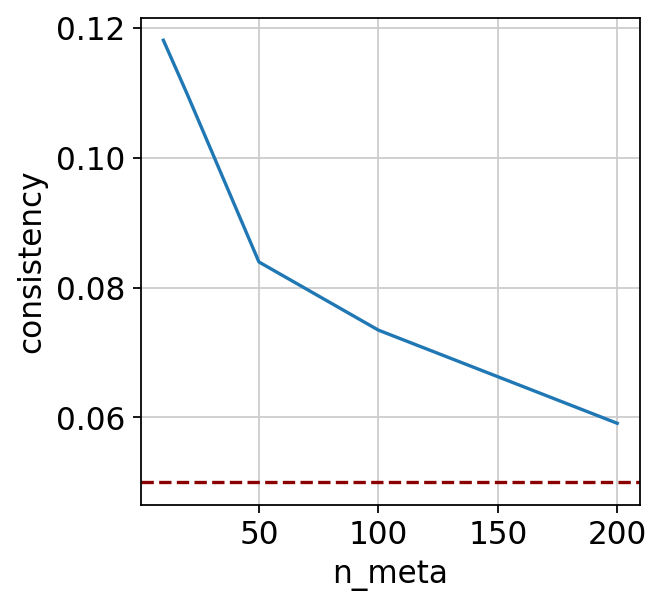

In [28]:
import seaborn as sns
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")

In [29]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [30]:
rna.obs["domain"] = "RNA"
atac.obs["domain"] = "ATAC"
combined = ad.concat([rna, atac])

/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [31]:
# sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
# sc.tl.umap(combined)
# sc.pl.umap(combined, color=["cell_type","domain"], wspace=0.65)

In [32]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

,0,1,2,3,4
0610031O16Rik,0.011603,0.092646,-0.003486,0.000729,-0.002723
1100001I12Rik,0.015022,-0.214319,-0.001010,0.000171,-0.001640
1110035H17Rik,-0.001933,0.033209,-0.003752,0.001202,-0.002448
1700001F09Rik,-0.008430,0.026573,-0.005594,0.002106,-0.010537
1700001J03Rik,0.005256,-0.100932,-0.002384,0.000457,-0.004293


In [33]:
rna.varm["X_glue"] = feature_embeddings.reindex(rna.var_names).to_numpy()
atac.varm["X_glue"] = feature_embeddings.reindex(atac.var_names).to_numpy()

In [34]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={'wspace': 1.2, 'hspace': 0.2})

# sc.pl.umap(combined[combined.obs['domain']=="RNA"], color=["cell_type"], wspace=1, ax=ax[0], show=False)
# sc.pl.umap(combined[combined.obs['domain']=="ATAC"], color=["cell_type"], wspace=1, ax=ax[1], show=False)
# plt.show()

In [35]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(atac.obsm["X_glue"], atac.obs["cell_type"])
print(neigh.predict(rna.obsm["X_glue"]))
print(neigh.predict_proba(rna.obsm["X_glue"]))

['Isthmic_nuclei' 'Isthmic_nuclei' 'PC' ... 'Progenitor_bipotent'
 'Progenitor_isthmic' 'PC_diff']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [36]:
import numpy as np
rna.obsm["tangram_ct_pred"] = pd.DataFrame(neigh.predict_proba(rna.obsm["X_glue"]),
                                           index=rna.obs_names, columns=np.sort(list(atac.obs["cell_type"].unique())))

In [37]:
rna.shape

(12707, 25993)

In [38]:
import numpy as np

# 获取 y 坐标
y_coords = rna.obsm['spatial'][:, 1]

# 计算 y 的最大值、最小值和平均值
y_max = np.max(y_coords)
y_min = np.min(y_coords)
y_avg = np.mean([y_max, y_min])

# 过滤掉 y 值小于平均值的观测数据
rnanew = rna[y_coords <= y_avg*0.8, :]


In [39]:
rnanew.shape

(12681, 25993)

['PC', 'Isthmic_nuclei', 'Progenitor_bipotent', 'GABA_DN', 'Interneuron_diff', 'PC_diff', 'Glut_DN_V', 'Progenitor_RL', 'Progenitor_isthmic', 'Parabrachial', 'Interneuron_early', 'GCP_prenatal', 'Glut_DN_P', 'GC_diff_prenatal', 'MBO']


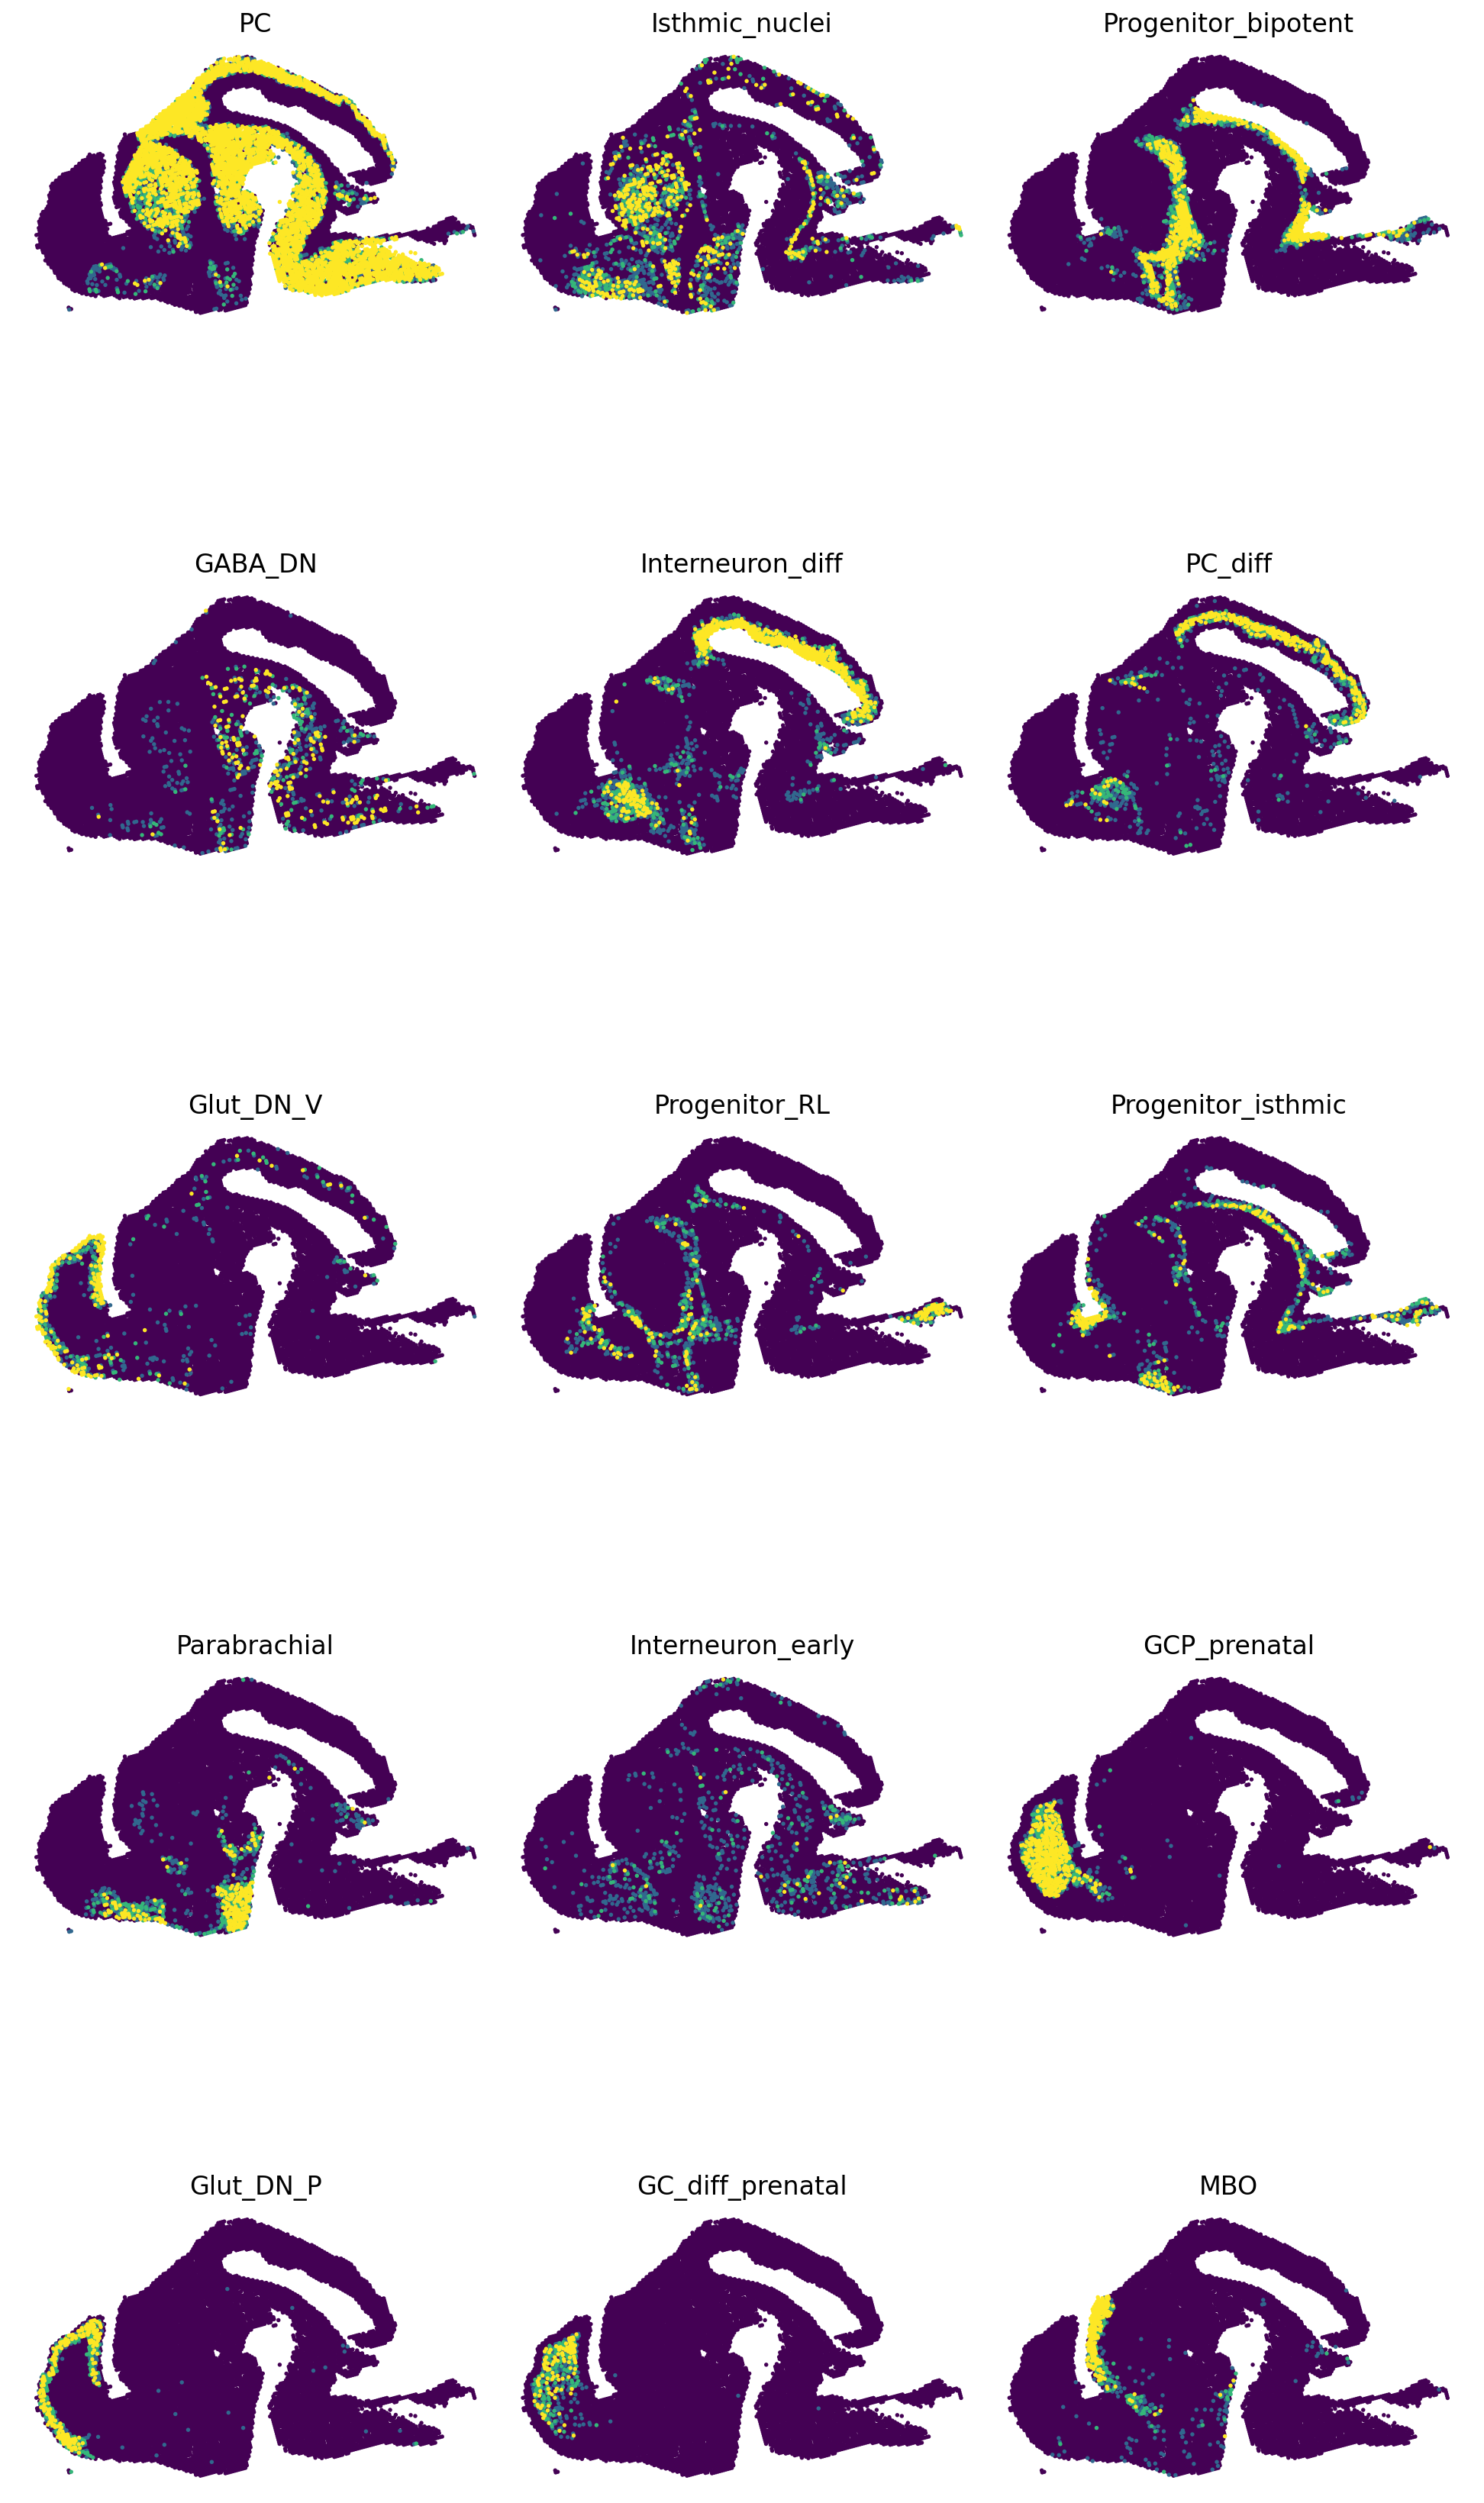

In [40]:
def construct_obs_plot(df_plot, adata, perc=0, suffix=None):
    # clip
    df_plot = df_plot.clip(df_plot.quantile(perc), df_plot.quantile(1 - perc), axis=1)

    # normalize
    df_plot = (df_plot - df_plot.min()) / (df_plot.max() - df_plot.min())

    if suffix:
        df_plot = df_plot.add_suffix(" ({})".format(suffix))
    adata.obs = pd.concat([adata.obs, df_plot], axis=1)
    
    
def plot_cell_annotation_sc(
    adata_sp, 
    annotation_list, 
    x="x", 
    y="y", 
    spot_size=None, 
    scale_factor=None, 
    perc=0,
    alpha_img=1.0,
    bw=False,
    ax=None
):
        
    # remove previous df_plot in obs
    adata_sp.obs.drop(annotation_list, inplace=True, errors="ignore", axis=1)

    # construct df_plot
    df = adata_sp.obsm["tangram_ct_pred"][annotation_list]
    construct_obs_plot(df, adata_sp, perc=perc)
    
    #non visium data 
    if 'spatial' not in adata_sp.obsm.keys():
        #add spatial coordinates to obsm of spatial data 
        coords = [[x,y] for x,y in zip(adata_sp.obs[x].values,adata_sp.obs[y].values)]
        adata_sp.obsm['spatial'] = np.array(coords)
    
    if 'spatial' not in adata_sp.uns.keys() and spot_size == None and scale_factor == None:
        raise ValueError("Spot Size and Scale Factor cannot be None when ad_sp.uns['spatial'] does not exist")
    
    #REVIEW
    if 'spatial' in adata_sp.uns.keys() and spot_size != None and scale_factor != None:
        raise ValueError("Spot Size and Scale Factor should be None when ad_sp.uns['spatial'] exists")
    
    sc.pl.spatial(
        adata_sp, color=annotation_list, cmap="viridis", show=False, frameon=False, spot_size=spot_size,
        scale_factor=scale_factor, alpha_img=alpha_img, bw=bw, ax=ax, colorbar_loc=None,ncols=3,wspace=0
    )

    adata_sp.obs.drop(annotation_list, inplace=True, errors="ignore", axis=1)

cell_type_counts = atac.obs['cell_type'].value_counts()
selected_cell_types = cell_type_counts[cell_type_counts >= 100].index.tolist()
print(selected_cell_types)

# tg.project_cell_annotations(ad_map, ad_sp1, annotation='subclass_label') 
##这里由于是FISH数据，每个spot都会对应一个细胞，如果是Visium，则需要对应多个细胞
# annotation_list = list(pd.unique(ad_sc.obs['subclass_label']))
sc.settings.set_figure_params(frameon=True, fontsize=15, facecolor='white',figsize=(5, 5)) #dpi=300, 
# import tangram as tg
# plot_cell_annotation_sc(rna, annotation_list, x='x', y='y', spot_size= 60, scale_factor=0.1, perc=0.001)
plot_cell_annotation_sc(rnanew, selected_cell_types, x='x', y='y',spot_size=2, perc=0.001)

In [41]:
atac.shape

(9402, 261642)

In [42]:
rna.shape

(12707, 25993)